Exact Survivor Function
=======================

This is equation 3.12 from [Hawkes, Jalali, Colqhoun (1990)](http://dx.doi.org/10.1098/rsta.1990.0129). A simpler form is also given in [Colquhoun, Hawkes and Srodzinski (1996)](http://dx.doi.org/10.1098/rsta.1996.0115).

These equations were performed in two parts: 

- the recurrence on the one side (recursion_formula.h). It is a set of template functions. This means it can be tested more simply on scalars (rather than matrices, as in the paper), as is done in tests/recursion_formula.cc.
- the acrutal survivor functions $^{A}R(t)$ and $^{F}R(t)$ are implemented as instances of exact_survivor.cc:ExactSurvivor::RecursionInterface. 


Checking the implementation
---------------------------

The classic  $Q$ matrix first:

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from numpy import array
from dcprogs.likelihood import QMatrix, DeterminantEq, Asymptotes, find_roots, ExactSurvivor
qmatrix = QMatrix( 
           array([[ -3050,        50,  3000,      0,    0 ], 
                  [ 2./3., -1502./3.,     0,    500,    0 ],  
                  [    15,         0, -2065,     50, 2000 ],  
                  [     0,     15000,  4000, -19000,    0 ],  
                  [     0,         0,    10,      0,  -10 ] ]), 2)


Then compares a few recursion terms by hand and by c++

In [4]:
from numpy import array
from dcprogs.likelihood import QMatrix, DeterminantEq, Asymptotes, find_roots, ExactSurvivor, eig
qmatrix = QMatrix( 
           array([[ -3050,        50,  3000,      0,    0 ], 
                  [ 2./3., -1502./3.,     0,    500,    0 ],  
                  [    15,         0, -2065,     50, 2000 ],  
                  [     0,     15000,  4000, -19000,    0 ],  
                  [     0,         0,    10,      0,  -10 ] ]), 2)

transitions = qmatrix.transpose()
tau = 1e-4
exact = ExactSurvivor(transitions, tau)
equation = DeterminantEq(transitions, tau)
roots = find_roots(equation)
approx = Asymptotes(equation, roots)
eigenvalues = eig(-transitions.matrix)[0]

def C_i10(i): 
    from numpy import zeros
    result = zeros((transitions.nopen, transitions.nopen), dtype='float64')
    for j in range(transitions.matrix.shape[0]):
        if i == j: continue
        result += np.dot(exact.D_af(i), exact.recursion_af(j, 0, 0)) / (eigenvalues[j] - eigenvalues[i])
        result -= np.dot(exact.D_af(j), exact.recursion_af(i, 0, 0)) / (eigenvalues[i] - eigenvalues[j])
    return result
    
def C_i20(i): 
    from numpy import zeros
    result = zeros((transitions.nopen, transitions.nopen), dtype='float64')
    for j in range(transitions.matrix.shape[0]):
        if i == j: continue
        result += ( np.dot(exact.D_af(i), exact.recursion_af(j, 1, 0)) 
                    + np.dot(exact.D_af(j), exact.recursion_af(i, 1, 0)) ) / (eigenvalues[j] - eigenvalues[i])
        result += ( np.dot(exact.D_af(i), exact.recursion_af(j, 1, 1)) 
                    - np.dot(exact.D_af(j), exact.recursion_af(i, 1, 1)) ) / (eigenvalues[j] - eigenvalues[i])**2
    return result

def C_i21(i): 
    result = np.dot(exact.D_af(i), exact.recursion_af(i, 1, 0)) 
    for j in range(transitions.matrix.shape[0]):
        if i == j: continue
        result -= np.dot(exact.D_af(j), exact.recursion_af(i, 1, 1)) / (eigenvalues[i] - eigenvalues[j])
    return result

def C_i22(i): return np.dot(exact.D_af(i), exact.recursion_af(i, 1, 1)) * 0.5 

print(np.all([np.all(abs(C_i10(i) - exact.recursion_af(i, 1, 0)) < 1e-8) for i in range(5)]))
print(np.all([np.all(abs(C_i20(i) - exact.recursion_af(i, 2, 0)) < 1e-8) for i in range(5)]))
print(np.all([np.all(abs(C_i21(i) - exact.recursion_af(i, 2, 1)) < 1e-8) for i in range(5)]))
print(np.all([np.all(abs(C_i22(i) - exact.recursion_af(i, 2, 2)) < 1e-8) for i in range(5)]))
    

True
True
True
True


Try and compare exact and approx via plot. The following is for $^{A}R(t)$ and $^{F}R(t)$.

<IPython.core.display.Javascript object>


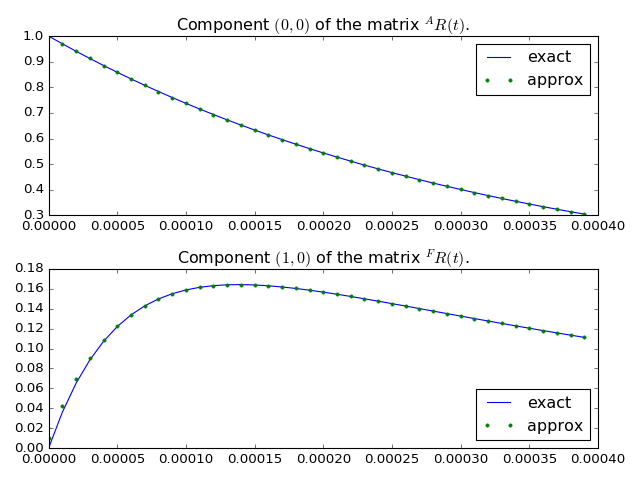

In [5]:
tau, i, j, n = 1e-4, 0, 0, 4



fig = plt.figure()

ax = fig.add_subplot(211)
transitions = qmatrix
exact = ExactSurvivor(transitions, tau)
equation = DeterminantEq(transitions, tau)
roots = find_roots(equation)
approx = Asymptotes(equation, roots)

x = np.arange(0, n * tau, tau / 10.)
ax.plot(x, exact.af(x)[:, i, j], label="exact")
ax.plot(x, approx(x)[:, i, j], '.', label="approx")
ax.set_title("Component ${0}$ of the matrix $^{{A}}R(t)$.".format((i, j)))
ax.legend()


ax = fig.add_subplot(212)
roots = find_roots(equation.transpose())
approx = Asymptotes(equation.transpose(), roots)

i, j = 1, 0
x = np.arange(0, n*tau, tau / 10.)
ax.plot(x, exact.fa(x)[:, i, j], label="exact")
ax.plot(x, approx(x)[:, i, j], '.', label="approx")
ax.set_title("Component ${0}$ of the matrix $^{{F}}R(t)$.".format((i, j)))
ax.legend(loc=0)

fig.tight_layout()